# Building an Apptainer image of Modulus v22.09

Instead of creating a definition file from scratch we can also convert the Docker iamge to Apptainer image.

```sh
sudo apptainer build modulus.img docker-archive://modulus_image_v22.09.tar.gz
```

If the Docker image is downloaded from [NVIDIA NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/modulus/containers/modulus), then just change the [URI location](https://apptainer.org/docs/user/main/docker_and_oci.html).

```sh
sudo apptainer build modulus.img docker://modulus_image_v22.09.tar.gz
```

# Getting the examples using the SSH key

Make sure you have uploaded your SSH key to Gitlab.

* Downlaod source code: `git clone git@gitlab.com:nvidia/modulus/modulus.git`
* Download the examples: `git clone git@gitlab.com:nvidia/modulus/examples.git`
* Download examples with checkpoints: `git clone git@gitlab.com:nvidia/modulus/examples.git`

# Port forwarding the Jupyter-lab
As per [this](https://stackoverflow.com/a/49536442/14598633) article, you don't need to map the ports from within the Apptainer image. I am not sure if this is the most efficient way to run a jupyter server which listens to any connection. Will deploy a script in future as Modulus supports interactive development in the newer versions.

```sh
[s.1915438@sl1 modulus22.09_apptainer]$ apptainer shell --contain --cleanenv modulus_22.09.img 
Apptainer> jupyter lab --ip 0.0.0.0 --no-browser --port=8888
```

Now one can port forward easily as follows: 

```sh
ssh -N -L 8888:localhost:8888 s.1915438@sunbird.swansea.ac.uk
```

In `8888:localhost:8888` the syntax is `LOCAL_PORT:HOSTNAME:REMOTE_PORT`

For compute node the same can be 

```sh
ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk
```

# Checking if the port is already occupied

```sh
[s.1915438@sl1 ~]$ netstat -tulpn | grep :8888
(Not all processes could be identified, non-owned process info
 will not be shown, you would have to be root to see it all.)
tcp        0      0 0.0.0.0:8888            0.0.0.0:*               LISTEN      220549/python3.8    
```

If a process is hindering then kill the process as follows:

```sh
(base) hell@Dell-Precision-T7910:~$ netstat -tulpn | grep :8888
(Not all processes could be identified, non-owned process info
 will not be shown, you would have to be root to see it all.)
tcp        0      0 127.0.0.1:8888          0.0.0.0:*               LISTEN      114998/ssh          
tcp6       0      0 ::1:8888                :::*                    LISTEN      114998/ssh          
(base) hell@Dell-Precision-T7910:~$ kill -9 114998
```

# A robust way to execute jobs
* Allocate the resources
Currently, Apptainer is fully functional on scs2043 only.

```sh
srun --pty --account=scw1901 --gres=gpu:1 --partition=accel_ai --nodelist=scs2043 /bin/bash
```
or just use this one when Apptainer is implemented system-wide.

```sh
srun --pty --account=scw1901 --gres=gpu:1 --partition=accel_ai /bin/bash
```

* Load Apptainer
```sh
module load apptainer/1.0.3 
```

* Start Modulus Apptainer image

Use this if you want to bind the `$(PWD)`.
```sh
apptainer shell --nv --contain --cleanenv --bind "$(pwd)":/data,/tmp:/tmp --env CUDA_VISIBLE_DEVICES=$CUDA_VISIBLE_DEVICES "/home/scratch/s.1915438/modulus22.09_apptainer/modulus_22.09.img"
```

Or use this to bind the whole `scratch` partition.

```sh
apptainer shell --nv --contain --cleanenv --bind "/scratch/s.1915438/":/data,/tmp:/tmp --home /data --env CUDA_VISIBLE_DEVICES=$CUDA_VISIBLE_DEVICES "/scratch/s.1915438/modulus22.09_apptainer/modulus_22.09.img"
```
* `--nv` : allows pasing NVIDIA GPUs
* `--contain`: no volume are binded by default

* Start the jupyter-lab server

```sh
jupyter lab --ip 0.0.0.0 --no-browser --port=8888
```

* Port forward
Start a new terminal. Use this format to port forward; `LOCAL_PORT:HOSTNAME:REMOTE_PORT`

```sh
ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk
```

just copy the address from the Jupyter server terminal:

```sh
http://hostname:8888/?token=43ea95796cc4dc4c64325ab5687701c59f9dc7a2ede559a0
```

and rename the hostname to the `localhost`

```sh
http://localhost:8888/?token=43ea95796cc4dc4c64325ab5687701c59f9dc7a2ede559a0
```

* For parallel training:

```sh
mpirun -np 2 python ldc_2d.py
```

where 2 is the number of GPUs allocated to the job. Make sure `CUDA_VISIBLE_DEVICES` is showing GPU numbers inside the container since we exported it from the host system.

Run this notebook exampel to learn more. Looks like the GPU is working.

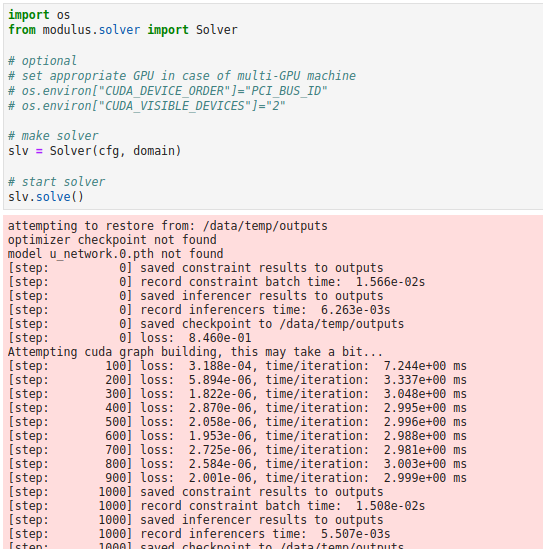

Have to see if there is any advantage with Hydra manager.